In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, normalize, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import StratifiedKFold

pd.options.display.max_rows = None
plt.style.use('dark_background')

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


In [3]:
# Loading train & test files
trainDf = pd.read_csv('../input/nlp-getting-started/train.csv')
testDf = pd.read_csv('../input/nlp-getting-started/test.csv')

In [4]:
trainDf = trainDf.set_index('id')
print(trainDf.duplicated().sum())
trainDf.drop_duplicates(inplace=True)

52


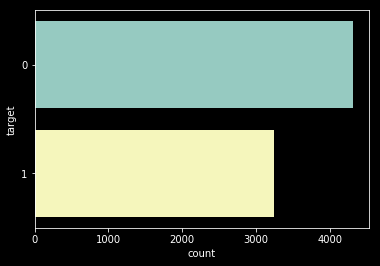

In [5]:
sns.countplot(y=trainDf.target)

In [6]:
trainDf.isnull().sum()

keyword       61
location    2500
text           0
target         0
dtype: int64

# **Keyword**

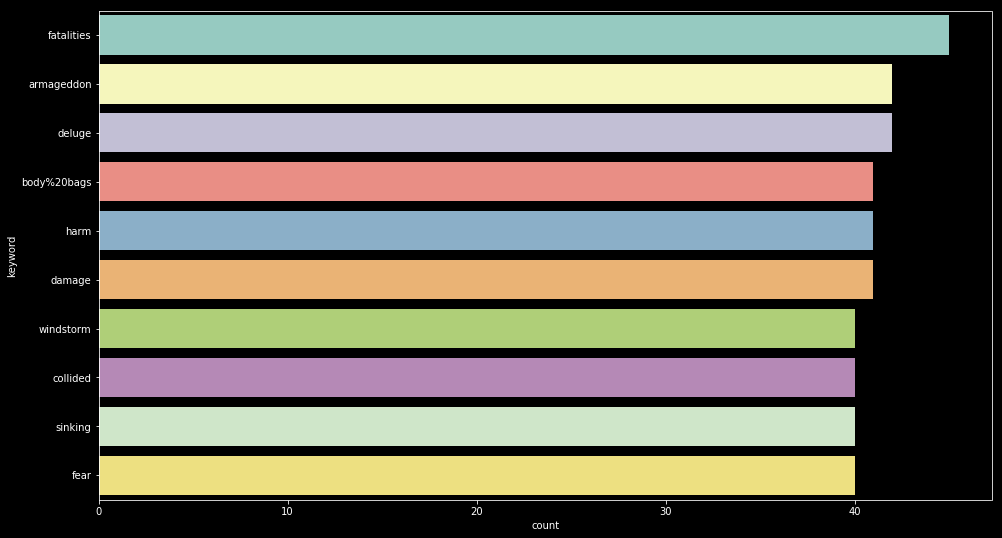

In [7]:
vctrain =  trainDf.keyword.value_counts()
plt.figure(figsize=(16,9))
sns.countplot(y=trainDf.keyword, order=vctrain.iloc[:10].index)

Text(0.5, 1.0, 'Top Keyword for Disaster')

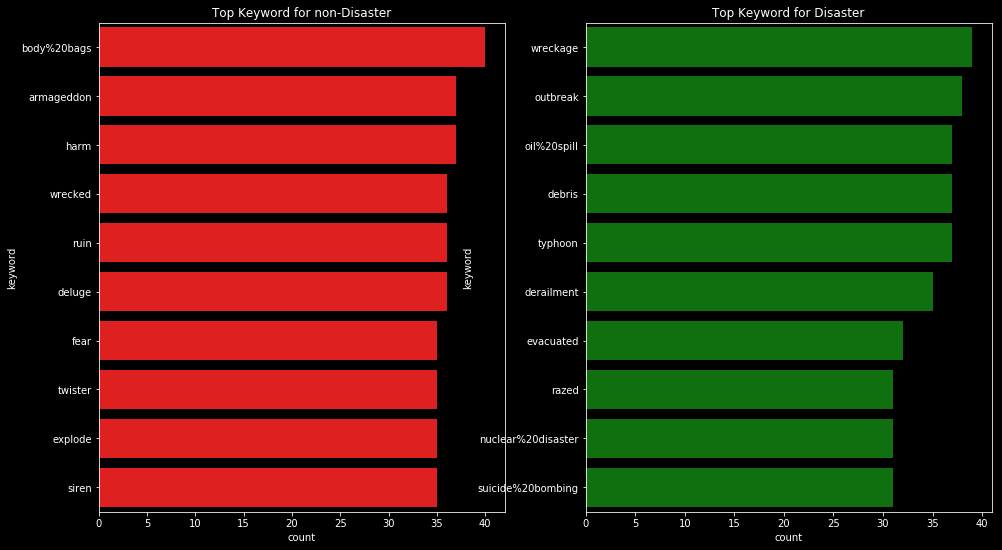

In [8]:
plt.figure(figsize=(16,9))
sns.countplot(y=trainDf.keyword, order=vctrain.iloc[:10].index)
plt.subplot(121)
sns.countplot(y=trainDf.keyword[trainDf.target == 0], order= trainDf.keyword[trainDf.target == 0].value_counts().iloc[:10].index, color='r')
plt.title('Top Keyword for non-Disaster')
plt.subplot(122)
sns.countplot(y=trainDf.keyword[trainDf.target == 1], order= trainDf.keyword[trainDf.target == 1].value_counts().iloc[:10].index, color='g')
plt.title('Top Keyword for Disaster')

## **Location**

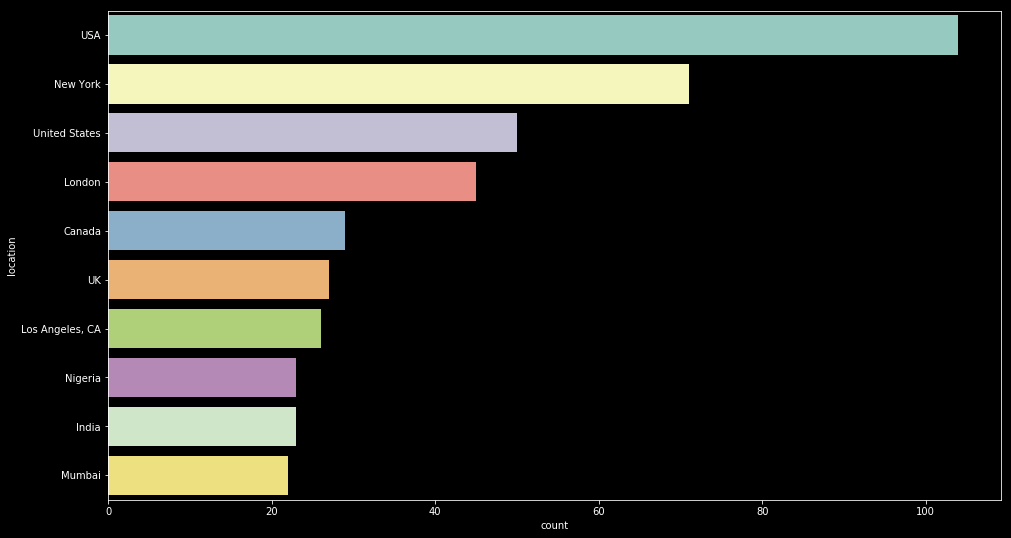

In [9]:
vcltrain =  trainDf.location.value_counts()
plt.figure(figsize=(16,9))
sns.countplot(y=trainDf.location, order=vcltrain.iloc[:10].index)

# Text

In [10]:
def tweet_cleaning(text):
    stopword = stopwords.words('english')
    lemmentizer = WordNetLemmatizer()
    text = text.lower()
    text =  re.sub(r"https?://\S+",'',text)
    text = re.sub(r"@\w+", '',text)
    text = re.sub(r"#", '',text)
    text = re.sub(r'\n',' ', text)
    text = re.sub('\s+', ' ', text).strip()
    text = word_tokenize(text)
    text = [word for word in text if word.isalnum()]
    text = [word for word in text if word not in stopword]
    text = [lemmentizer.lemmatize(word) for word in text]
    text = " ".join(word for word in text)
    
    return text

In [11]:
def mentions(text):
    text = re.findall(r"@\w+",text)
    return [txt.strip('@') for txt in text]

In [12]:
def hashtags(text):
    text = re.findall(r"#\w+",text)
    return [txt.strip('#') for txt in text]

In [13]:
trainDf['clean_tweets'] = trainDf.text.apply(tweet_cleaning)
trainDf['mentions'] = trainDf.text.apply(mentions)
trainDf['hashtags'] = trainDf.text.apply(hashtags)

In [14]:
testDf['clean_tweets'] = testDf.text.apply(tweet_cleaning)
testDf['mentions'] = testDf.text.apply(mentions)
testDf['hashtags'] = testDf.text.apply(hashtags)

In [15]:
vdata = pd.concat([trainDf.drop('target', axis=1), testDf], axis=0)
vdata.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,clean_tweets,hashtags,id,keyword,location,mentions,text
1,deed reason earthquake may allah forgive u,[earthquake],NaN,NaN,NaN,[],Our Deeds are the Reason of this #earthquake M...
4,forest fire near la ronge sask canada,[],NaN,NaN,NaN,[],Forest fire near La Ronge Sask. Canada
5,resident asked place notified officer evacuati...,[],NaN,NaN,NaN,[],All residents asked to 'shelter in place' are ...
6,people receive wildfire evacuation order calif...,[wildfires],NaN,NaN,NaN,[],"13,000 people receive #wildfires evacuation or..."
7,got sent photo ruby alaska smoke wildfire pour...,"[Alaska, wildfires]",NaN,NaN,NaN,[],Just got sent this photo from Ruby #Alaska as ...


In [16]:
vectorizer = TfidfVectorizer()
vectorizer.fit(vdata.clean_tweets)
vectorize_tweets_train = vectorizer.transform(trainDf.clean_tweets)
vectorize_tweets_test = vectorizer.transform(testDf.clean_tweets)
train = pd.DataFrame(vectorize_tweets_train.toarray(),index=trainDf.index)
test = pd.DataFrame(vectorize_tweets_test.toarray(), index=testDf.index)

In [17]:
train = pd.concat([train, trainDf.target],axis=1)

In [18]:
X = train.iloc[:,:-1].values
y = train.target.values

In [19]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3)

# Model

In [20]:
def train_model(clf, Xtrain=Xtrain, ytrain=ytrain, Xtest=Xtest, ytest=ytest,nsplit=3):
    skf = StratifiedKFold(n_splits=nsplit)
    
    for trainIndex, testIndex in skf.split(Xtrain,ytrain):
        clf.fit(Xtrain[trainIndex],ytrain[trainIndex])
        pred = clf.predict(Xtrain[testIndex])

        print("Confusion Matrix :\n", confusion_matrix(ytrain[testIndex], pred))
        print("Classification Report :\n", classification_report(ytrain[testIndex], pred))
        print("Accuracy :\n", accuracy_score(ytrain[testIndex], pred))
        
    pred = clf.predict(Xtest)
    print("\033[1mConfusion Matrix :\033[0m\n", confusion_matrix(ytest, pred))
    print("\033[1mClassification Report :\033[0m\n", classification_report(ytest, pred))
    print("\033[1mAccuracy :\033[0m\n", accuracy_score(ytest, pred))
    
    return clf

## Multinomial Naive Bayes 

In [21]:
mnb = MultinomialNB(alpha=1.5)

In [22]:
mnb = train_model(mnb)

Confusion Matrix :
 [[946  72]
 [330 416]]
Classification Report :
               precision    recall  f1-score   support

           0       0.74      0.93      0.82      1018
           1       0.85      0.56      0.67       746

    accuracy                           0.77      1764
   macro avg       0.80      0.74      0.75      1764
weighted avg       0.79      0.77      0.76      1764

Accuracy :
 0.7721088435374149
Confusion Matrix :
 [[953  65]
 [330 416]]
Classification Report :
               precision    recall  f1-score   support

           0       0.74      0.94      0.83      1018
           1       0.86      0.56      0.68       746

    accuracy                           0.78      1764
   macro avg       0.80      0.75      0.75      1764
weighted avg       0.79      0.78      0.76      1764

Accuracy :
 0.7760770975056689
Confusion Matrix :
 [[968  50]
 [302 444]]
Classification Report :
               precision    recall  f1-score   support

           0       0.76  

## Gaussian Naive Bayes 

In [23]:
gnb = GaussianNB(var_smoothing=1e-01)

In [24]:
gnb = train_model(gnb)

Confusion Matrix :
 [[657 361]
 [132 614]]
Classification Report :
               precision    recall  f1-score   support

           0       0.83      0.65      0.73      1018
           1       0.63      0.82      0.71       746

    accuracy                           0.72      1764
   macro avg       0.73      0.73      0.72      1764
weighted avg       0.75      0.72      0.72      1764

Accuracy :
 0.7205215419501134
Confusion Matrix :
 [[654 364]
 [147 599]]
Classification Report :
               precision    recall  f1-score   support

           0       0.82      0.64      0.72      1018
           1       0.62      0.80      0.70       746

    accuracy                           0.71      1764
   macro avg       0.72      0.72      0.71      1764
weighted avg       0.73      0.71      0.71      1764

Accuracy :
 0.7103174603174603
Confusion Matrix :
 [[666 352]
 [144 602]]
Classification Report :
               precision    recall  f1-score   support

           0       0.82  

## Ridge Classifier

In [25]:
rgc = RidgeClassifier(alpha=2)

In [26]:
rgc = train_model(rgc)

Confusion Matrix :
 [[914 104]
 [286 460]]
Classification Report :
               precision    recall  f1-score   support

           0       0.76      0.90      0.82      1018
           1       0.82      0.62      0.70       746

    accuracy                           0.78      1764
   macro avg       0.79      0.76      0.76      1764
weighted avg       0.78      0.78      0.77      1764

Accuracy :
 0.7789115646258503
Confusion Matrix :
 [[931  87]
 [286 460]]
Classification Report :
               precision    recall  f1-score   support

           0       0.76      0.91      0.83      1018
           1       0.84      0.62      0.71       746

    accuracy                           0.79      1764
   macro avg       0.80      0.77      0.77      1764
weighted avg       0.80      0.79      0.78      1764

Accuracy :
 0.7885487528344671
Confusion Matrix :
 [[936  82]
 [279 467]]
Classification Report :
               precision    recall  f1-score   support

           0       0.77  

## Desicion Tree

In [27]:
dtc = DecisionTreeClassifier()

In [28]:
dtc = train_model(dtc)

Confusion Matrix :
 [[801 217]
 [266 480]]
Classification Report :
               precision    recall  f1-score   support

           0       0.75      0.79      0.77      1018
           1       0.69      0.64      0.67       746

    accuracy                           0.73      1764
   macro avg       0.72      0.72      0.72      1764
weighted avg       0.72      0.73      0.72      1764

Accuracy :
 0.7261904761904762
Confusion Matrix :
 [[781 237]
 [266 480]]
Classification Report :
               precision    recall  f1-score   support

           0       0.75      0.77      0.76      1018
           1       0.67      0.64      0.66       746

    accuracy                           0.71      1764
   macro avg       0.71      0.71      0.71      1764
weighted avg       0.71      0.71      0.71      1764

Accuracy :
 0.7148526077097506
Confusion Matrix :
 [[791 227]
 [246 500]]
Classification Report :
               precision    recall  f1-score   support

           0       0.76  

## Random Forest

In [29]:
rfc = RandomForestClassifier(n_estimators=200)

In [30]:
rfc = train_model(rfc)

Confusion Matrix :
 [[909 109]
 [311 435]]
Classification Report :
               precision    recall  f1-score   support

           0       0.75      0.89      0.81      1018
           1       0.80      0.58      0.67       746

    accuracy                           0.76      1764
   macro avg       0.77      0.74      0.74      1764
weighted avg       0.77      0.76      0.75      1764

Accuracy :
 0.7619047619047619
Confusion Matrix :
 [[896 122]
 [303 443]]
Classification Report :
               precision    recall  f1-score   support

           0       0.75      0.88      0.81      1018
           1       0.78      0.59      0.68       746

    accuracy                           0.76      1764
   macro avg       0.77      0.74      0.74      1764
weighted avg       0.76      0.76      0.75      1764

Accuracy :
 0.7590702947845805
Confusion Matrix :
 [[926  92]
 [318 428]]
Classification Report :
               precision    recall  f1-score   support

           0       0.74  

## XGBOOST

In [31]:
xgc = XGBClassifier(n_jobs= -1, warm_start = True)

In [32]:
xgc = train_model(xgc)

Confusion Matrix :
 [[899 119]
 [321 425]]
Classification Report :
               precision    recall  f1-score   support

           0       0.74      0.88      0.80      1018
           1       0.78      0.57      0.66       746

    accuracy                           0.75      1764
   macro avg       0.76      0.73      0.73      1764
weighted avg       0.76      0.75      0.74      1764

Accuracy :
 0.7505668934240363
Confusion Matrix :
 [[893 125]
 [323 423]]
Classification Report :
               precision    recall  f1-score   support

           0       0.73      0.88      0.80      1018
           1       0.77      0.57      0.65       746

    accuracy                           0.75      1764
   macro avg       0.75      0.72      0.73      1764
weighted avg       0.75      0.75      0.74      1764

Accuracy :
 0.746031746031746
Confusion Matrix :
 [[906 112]
 [309 437]]
Classification Report :
               precision    recall  f1-score   support

           0       0.75   

## Support Vector

In [33]:
svc = SVC(C=0.5)

In [34]:
svc = train_model(svc)

Confusion Matrix :
 [[998  20]
 [485 261]]
Classification Report :
               precision    recall  f1-score   support

           0       0.67      0.98      0.80      1018
           1       0.93      0.35      0.51       746

    accuracy                           0.71      1764
   macro avg       0.80      0.67      0.65      1764
weighted avg       0.78      0.71      0.68      1764

Accuracy :
 0.713718820861678
Confusion Matrix :
 [[1008   10]
 [ 517  229]]
Classification Report :
               precision    recall  f1-score   support

           0       0.66      0.99      0.79      1018
           1       0.96      0.31      0.46       746

    accuracy                           0.70      1764
   macro avg       0.81      0.65      0.63      1764
weighted avg       0.79      0.70      0.65      1764

Accuracy :
 0.7012471655328798
Confusion Matrix :
 [[1007   11]
 [ 486  260]]
Classification Report :
               precision    recall  f1-score   support

           0      

# Prediction

In [35]:
prediction = rgc.predict(test)
result = pd.DataFrame(prediction, index=testDf.id, columns=['target'])

In [36]:
result = result.reset_index()

In [37]:
result.columns = [['id', 'target']]

In [38]:
result.index = range(1, 3264, 1)

In [39]:
result.to_csv('nlp_sub1.csv',index=False)

In [40]:
result

,id,target
1,0,1
2,2,1
3,3,1
4,9,1
5,11,1
6,12,1
7,21,0
8,22,0
9,27,0
10,29,0
